<a href="https://colab.research.google.com/github/ibacaraujo/to-tensorflow2/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

This notebook use the Auto MPG dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. A description of many automobiles from that time period will be provided to the model. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [0]:
# Use seaborn for pairplot
!pip install -q seaborn

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

     |████████████████████████████████| 87.9MB 427kB/s 
     |████████████████████████████████| 501kB 52.5MB/s 
     |████████████████████████████████| 3.1MB 39.5MB/s 
1.14.0


## The Auto MPG dataset

### Get the data

In [4]:
# Download the dataset
dataset_path = keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

In [5]:
# Import it using pandas
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values='?', comment='\t',
                         sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
# To keep it simple, drop those rows
dataset = dataset.dropna()

In [8]:
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

In [11]:
# The 'Origin' column is really categorical, not numeric. So, convert to one-hot
dataset['Origin'].value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

In [0]:
origin = dataset.pop('Origin')

In [13]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Split the data into train and test

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set

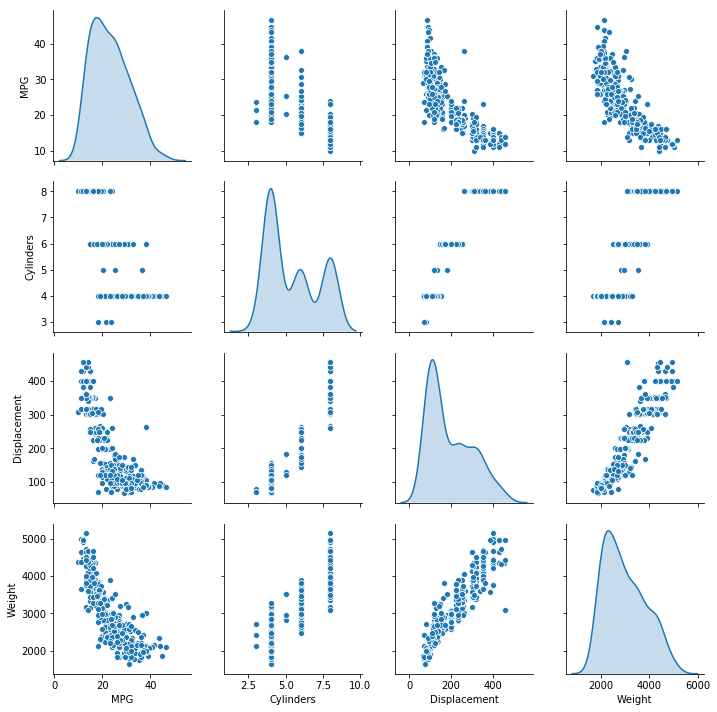

In [15]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']],
             diag_kind='kde')

Also look at the overall statistics

In [16]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Split features from labels

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Looking at the train_stats block above we can observe how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

**Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.**

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

**Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier. That includes the test set as well as live data when the model is used in production.**

## The model!

### Build the model!

In [21]:
print(train_dataset.keys())
print(len(train_dataset.keys()))

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')
9


In [0]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), 
      layers.Dense(64, activation='relu'), 
      layers.Dense(1) # output layer that returns a single, continuous value
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(optimizer=optimizer,
               loss='mse',
               metrics=['mae', 'mse'])
  
  return model

In [25]:
model = build_model()

W0810 17:53:35.145928 140233763256192 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Inspect the model

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Try out the model. Take batch of 10 examples and call model.predict on it
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.10714304],
       [-0.04766185],
       [-0.6214305 ],
       [-0.2566306 ],
       [-0.31002006],
       [ 0.01368933],
       [-0.333973  ],
       [ 0.07209626],
       [-0.07637998],
       [-0.3544937 ]], dtype=float32)

It seems to be working and it produces a result of the expected shape and type

### Train the model

In [29]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
EPOCHS = 1000

# Record the training and validation accuracy in the history object
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split=0.2, verbose=0,
  callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [31]:
# Visual the model's training progress using the stats stored in the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.362761,0.964846,2.362761,8.284591,2.180920,8.284592,995
996,2.525745,1.016905,2.525745,8.306728,2.288059,8.306727,996
997,2.185443,0.959842,2.185443,8.107992,2.222910,8.107992,997
998,2.446055,0.998309,2.446055,8.358526,2.243484,8.358526,998
999,2.265271,0.971847,2.265270,8.958926,2.428203,8.958926,999


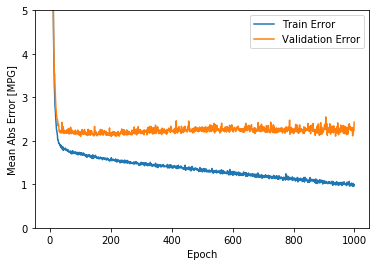

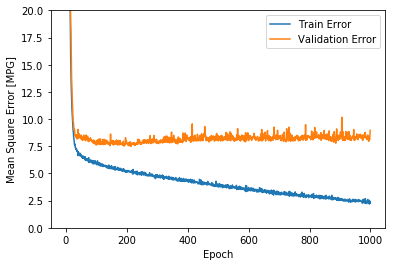

In [35]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Validation Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
  
plot_history(history)

Graphs show no improvements after close to 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We will use EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without improving, then automatically stop the training


......................................................

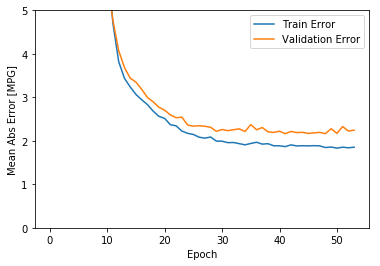

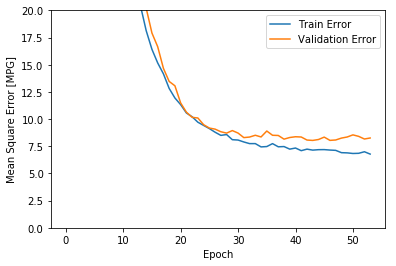

In [37]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [42]:
# Test the model generalization
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} MPG'.format(mae))

Testing set Mean Abs Error:  1.76 MPG


### Make predictions

In [48]:
model.predict(normed_test_data)[:5]

array([[15.852088 ],
       [10.6609535],
       [10.876488 ],
       [22.643646 ],
       [21.408863 ]], dtype=float32)

In [49]:
model.predict(normed_test_data).flatten()[:5]

array([15.852088 , 10.6609535, 10.876488 , 22.643646 , 21.408863 ],
      dtype=float32)

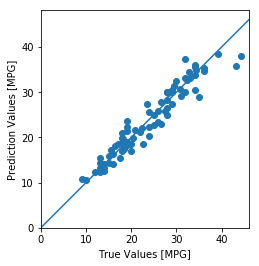

In [51]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Prediction Values [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well! Let's take a look at the error distribution

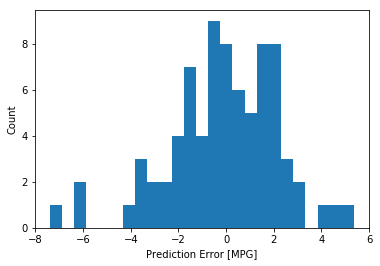

In [52]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

